In [66]:
LANGUAGE = 'english'

### Setting Up

In [67]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [68]:
def load_results_dataframe(language: str) -> pd.DataFrame:
    df = pd.read_csv(f'https://scandeval.com/{language}-nlu.csv')

    datasets = ['model_id', 'rank']
    for task in ['ner', 'sent', 'la', 'qa']:
        datasets.extend([
            dataset
            for dataset in df.columns
            if dataset_to_task.get(dataset) == task
        ])
    df = df[datasets]
    
    df['generative'] = df.model_id.map(lambda x: "few-shot" in x)
    df.set_index('model_id', inplace=True)
    
    return df

In [69]:
dataset_to_task = dict(
    # Danish
    dansk='ner',
    angry_tweets='sent',
    scala_da='la',
    scandiqa_da='qa',

    # Norwegian
    norne_nb='ner',
    norne_nn='ner',
    norec='sent',
    scala_nb='la',
    scala_nn='la',
    norquad='qa',

    # Swedish
    suc3='ner',
    swerec='sent',
    scala_sv='la',
    scandiqa_sv='qa',

    # Icelandic
    mim_gold_ner='ner',
    scala_is='la',
    nqii='qa',

    # Faroese
    fone='ner',
    scala_fo='la',

    # German
    germeval='ner',
    sb10k='sent',
    scala_de='la',
    germanquad='qa',

    # Dutch
    conll_nl='ner',
    dutch_social='sent',
    scala_nl='la',
    squad_nl='qa',

    # English
    conll_en='ner',
    sst5='sent',
    scala_en='la',
    squad='qa',
)
language_title = LANGUAGE.replace('-', ' ').title()

In [70]:
df = load_results_dataframe(language=LANGUAGE)
df.head()

,rank,conll_en,sst5,scala_en,squad,generative
model_id,,,,,,
microsoft/deberta-v3-large,1.09,91.88,64.04,75.10,74.47,False
microsoft/deberta-v3-base,1.28,91.57,61.66,68.74,68.69,False
google/electra-base-discriminator,1.39,89.83,63.55,67.87,58.27,False
FacebookAI/roberta-large,1.42,91.53,62.92,48.77,71.23,False
"gpt-4-0613 (few-shot, val)",1.44,78.06,69.06,55.76,67.35,True


## Plots

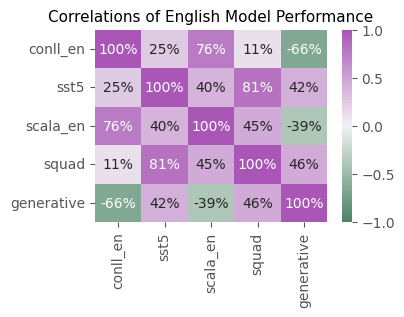

In [71]:
num_datasets = len(df.columns) - 1
plt.figure(figsize=(3 * num_datasets / 4, 2 * num_datasets / 4))
sns.heatmap(
    df.drop(columns='rank').corr(), 
    annot=True, 
    fmt=".0%", 
    vmin=-1, 
    vmax=1, 
    cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
)
plt.title(f"Correlations of {language_title} Model Performance", fontsize=11)
plt.savefig(f"/Users/dan/Downloads/correlation-{LANGUAGE}.png", bbox_inches='tight')
plt.show()

Using 38 neighbours.


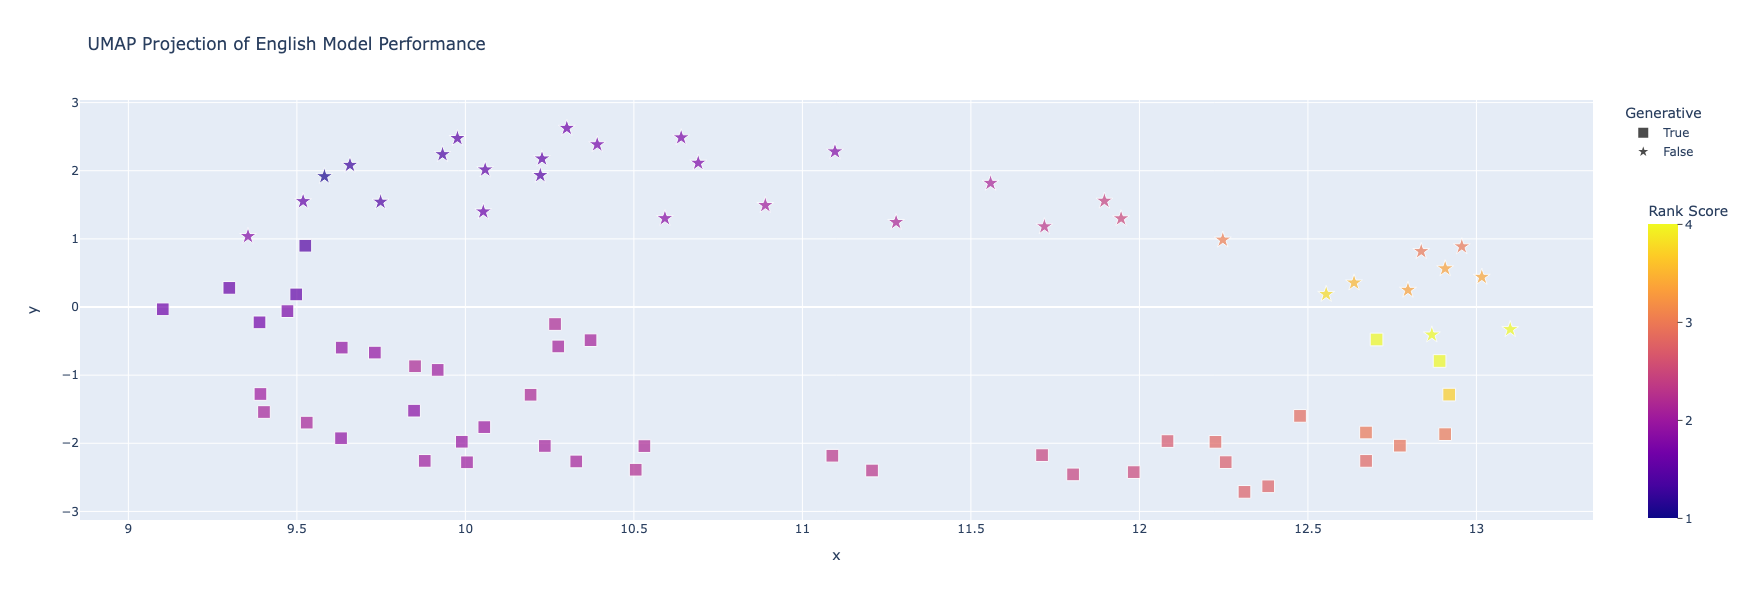

In [74]:
n_neighbours = (len(df) - 1) // 2
print(f"Using {n_neighbours} neighbours.")
umap = UMAP(n_neighbors=n_neighbours, n_components=2, random_state=4242, n_jobs=1)
umap_projection = umap.fit_transform(df.drop(columns=["generative", "rank"]))

if df.generative.iloc[0]:
    symbol_sequence = ["square", "star"]
    traceorder = "normal"
else:
    symbol_sequence = ["star", "square"]
    traceorder = "reversed"

fig = px.scatter(
    x=umap_projection[:, 0], 
    y=umap_projection[:, 1], 
    color=df['rank'],
    color_continuous_scale=px.colors.sequential.Plasma,
    range_color=[1, 4],
    symbol=df.generative,
    symbol_sequence=symbol_sequence,
    size=[20] * len(df),
    size_max=9,
    hover_name=df.index.tolist(),
    width=800,
    height=600,
    title=f"UMAP Projection of {language_title} Model Performance",
    labels=dict(color="Rank Score", symbol='Generative'),
    template='plotly',
)
fig.update_layout(
    coloraxis_colorbar=dict(
        yanchor="top", y=0.78, x=1.03, ticks="outside", len=0.8, dtick=1
    ),
    legend_traceorder=traceorder,
)